### Student Information
Name:游雅雯 Evan Yu

Student ID:106065501

---

### Outlines of my processing steps

- Import

   (1) Import all the library/module I need at beginin

   (2) Check missing and duplicate for my data
   

- Data processing

   (1) I have checked the distribution of positive/ngative label of 3 dataset

   (2) I try to capture the difference trend/features between two labels and find something interesting

---

### Import

* Import libraries and modules

In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict 
from sklearn.feature_extraction.text import CountVectorizer

# my functions
import helpers.my_function as myf
import helpers.data_mining_helpers as dmh
import helpers.text_analysis as ta

 - Import raw data

    (1) There are only two columns in each file and the column is seperated by "\s\s\t"

In [2]:
amazon = pd.read_csv('./sentiment_labelled_sentences/amazon_cells_labelled.txt', sep='\t', header=None, engine='python',names=['text','label'])
imdb = pd.read_csv('./sentiment_labelled_sentences/imdb_labelled.txt', sep='\s\s\t', encoding='UTF-8', header=None, engine='python',names=['text','label'])
yelp = pd.read_csv('./sentiment_labelled_sentences/yelp_labelled.txt', sep='\t', header=None, engine='python',names=['text','label'])
print(amazon.shape)
print(imdb.shape)
print(yelp.shape)

(1000, 2)
(1000, 2)
(1000, 2)


---

    (2) There are some weird words, seems like ASCII, in imdb_labelled.txt. Thus, I add parameter "encoding='UTF-8' to let it shows normally then replace them later.

In [3]:
for idx,s in enumerate(amazon.text):  
  string = re.sub(r"\\x\d*", " ",str(s))
  amazon.text.loc[idx] = myf.clean_str(str(string))

for idx,s in enumerate(imdb.text):  
  string = re.sub(r"\\x\d*", " ",str(s))
  imdb.text.loc[idx] = myf.clean_str(str(string))

for idx,s in enumerate(yelp.text):  
  string = re.sub(r"\\x\d*", " ",str(s))
  yelp.text.loc[idx] = myf.clean_str(str(string))

C:\Users\Nini\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---

    (3) Check and remove missing

In [4]:
print("amazon:\n",amazon.isnull().apply(lambda x: dmh.check_missing_values(x),axis=0),end='\n\n')
print("imdb:\n",imdb.isnull().apply(lambda x: dmh.check_missing_values(x),axis=0),end='\n\n')
print("yelp:\n",yelp.isnull().apply(lambda x: dmh.check_missing_values(x),axis=0),end='\n\n')

amazon:
 text     (The amoung of missing records is: , 0)
label    (The amoung of missing records is: , 0)
dtype: object

imdb:
 text     (The amoung of missing records is: , 0)
label    (The amoung of missing records is: , 0)
dtype: object

yelp:
 text     (The amoung of missing records is: , 0)
label    (The amoung of missing records is: , 0)
dtype: object



---

    (4) Check and remove duplicate

In [5]:
print("amazon duplicated: ",sum(amazon.duplicated('text')))
print("imdb duplicated: ",sum(imdb.duplicated('text')))
print("yelp duplicated: ",sum(yelp.duplicated('text')))

amazon duplicated:  18
imdb duplicated:  4
yelp duplicated:  5


In [6]:
amazon_dup_idx=myf.get_duplicated_idx(amazon,'text')
amazon_del_dup=amazon.drop(amazon.index[amazon_dup_idx])
print(amazon_del_dup.shape)

imdb_dup_idx=myf.get_duplicated_idx(imdb,'text')
imdb_del_dup=imdb.drop(imdb.index[imdb_dup_idx])
print(imdb_del_dup.shape)

yelp_dup_idx=myf.get_duplicated_idx(yelp,'text')
yelp_del_dup=yelp.drop(yelp.index[yelp_dup_idx])
print(yelp_del_dup.shape)

(982, 2)
(996, 2)
(995, 2)


---

### Data Processing

- Label distribution of different dataset

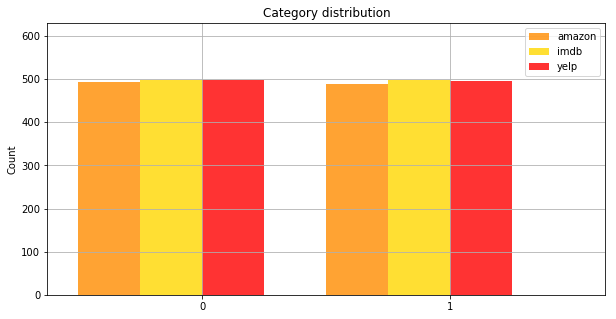

In [7]:
import matplotlib.pyplot as plt
# Setting the positions and width for the bars
pos = list(range(2)) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with amazon data,
# in position pos,
plt.bar(pos, amazon_del_dup.label.value_counts(), width, alpha=0.8,color='darkorange',label='amazon data set') 

# Create a bar with imdb data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], imdb_del_dup.label.value_counts(), width, alpha=0.8, color='gold',label='imdb data set') 

# Create a bar with imdb data,
# in position pos + some width buffer,
plt.bar([p + 2*width for p in pos], yelp_del_dup.label.value_counts(), width, alpha=0.8, color='r',label='yelp data set') 

# Set the y axis label
ax.set_ylabel('Count')

# Set the chart's title
ax.set_title('Category distribution')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(yelp_del_dup.label.index)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 630])

# Adding the legend and showing the plot
plt.legend(['amazon', 'imdb','yelp'], loc='upper right')
plt.grid()
plt.show()

We can find that the positive and negtive labels of three dataset are almost 1:1.

---

- Feature subset selection:

    As I mentioned above, because the quantity of two labels are almost equal, I think the neutral words may be twice as much as
    
    the positive and negative words. Thus, I want to get the disjoint words from positive group and negative group.

In [8]:
#For amazon dataset
#1.seperate postive and negative data
amazon_pos_idx=myf.get_pos_neg_texts(amazon_del_dup.label,1)
amazon_neg_idx=myf.get_pos_neg_texts(amazon_del_dup.label,0)
amazon_pos_text=amazon_del_dup.iloc[amazon_pos_idx]
amazon_neg_text=amazon_del_dup.iloc[amazon_neg_idx]

#2.creat countvectorize for each group
amazon_pos_CV = CountVectorizer()
amazon_pos_counts = amazon_pos_CV.fit_transform(amazon_pos_text.text)

amazon_neg_CV = CountVectorizer()
amazon_neg_counts = amazon_neg_CV.fit_transform(amazon_neg_text.text)

#3. get disjoint words
amazon_pos_set=set(amazon_pos_CV.get_feature_names())
amazon_neg_set=set(amazon_neg_CV.get_feature_names())
amazon_words_Set=amazon_pos_set^amazon_neg_set
len(amazon_words_Set)

1323

In [9]:
#For imdb dataset
#1.seperate postive and negative data
imdb_pos_idx=myf.get_pos_neg_texts(imdb_del_dup.label,1)
imdb_neg_idx=myf.get_pos_neg_texts(imdb_del_dup.label,0)
imdb_pos_text=imdb_del_dup.iloc[imdb_pos_idx]
imdb_neg_text=imdb_del_dup.iloc[imdb_neg_idx]

#2.creat countvectorize for each group
imdb_pos_CV = CountVectorizer()
imdb_pos_counts = imdb_pos_CV.fit_transform(imdb_pos_text.text)

imdb_neg_CV = CountVectorizer()
imdb_eg_counts = imdb_neg_CV.fit_transform(imdb_neg_text.text)

#3. get disjoint words
imdb_pos_set=set(imdb_pos_CV.get_feature_names())
imdb_neg_set=set(imdb_neg_CV.get_feature_names())
imdb_words_Set=imdb_pos_set^imdb_neg_set
len(imdb_words_Set)

2382

In [10]:
#For yelp dataset
#1.seperate postive and negative data
yelp_pos_idx=myf.get_pos_neg_texts(yelp_del_dup.label,1)
yelp_neg_idx=myf.get_pos_neg_texts(yelp_del_dup.label,0)
yelp_pos_text=yelp_del_dup.iloc[yelp_pos_idx]
yelp_neg_text=yelp_del_dup.iloc[yelp_neg_idx]

#2.creat countvectorize for each group
yelp_pos_CV = CountVectorizer()
yelp_pos_counts = yelp_pos_CV.fit_transform(yelp_pos_text.text)

yelp_neg_CV = CountVectorizer()
yelp_neg_counts = yelp_neg_CV.fit_transform(yelp_neg_text.text)

#3. get disjoint words
yelp_pos_set=set(yelp_pos_CV.get_feature_names())
yelp_neg_set=set(yelp_neg_CV.get_feature_names())
yelp_words_Set=yelp_pos_set^yelp_neg_set
len(yelp_words_Set)

1477

In [11]:
#creat countvectorize for amazon dataset
amazon_CV = CountVectorizer()
amazon_del_dup_counts = amazon_CV.fit_transform(amazon_del_dup.text)  

#creat countvectorize for amazon dataset
imdb_CV = CountVectorizer()
imdb_del_dup_counts = imdb_CV.fit_transform(imdb_del_dup.text)  

#creat countvectorize for amazon dataset
yelp_CV = CountVectorizer()
yelp_del_dup_counts = yelp_CV.fit_transform(yelp_del_dup.text)  


In [13]:
#get the index which are disjoint words locate
amazon_idx=myf.get_idx(amazon_words_Set,amazon_CV.get_feature_names())
imdb_idx=myf.get_idx(imdb_words_Set,imdb_CV.get_feature_names())
yelp_idx=myf.get_idx(yelp_words_Set,yelp_CV.get_feature_names())

In [14]:
print(amazon_del_dup_counts[:,amazon_idx].toarray()[amazon_pos_idx,:].shape)
print(amazon_del_dup_counts[:,amazon_idx].toarray()[amazon_neg_idx,:].shape)

print(imdb_del_dup_counts[:,imdb_idx].toarray()[imdb_pos_idx,:].shape)
print(imdb_del_dup_counts[:,imdb_idx].toarray()[imdb_neg_idx,:].shape)

print(yelp_del_dup_counts[:,yelp_idx].toarray()[yelp_pos_idx,:].shape)
print(yelp_del_dup_counts[:,yelp_idx].toarray()[yelp_neg_idx,:].shape)

(489, 1323)
(493, 1323)
(498, 2382)
(498, 2382)
(499, 1477)
(496, 1477)


In [15]:
amazon_disjoint_count = sum(amazon_del_dup_counts[:,amazon_idx].toarray())
amazon_disjoint_count_sort = sorted(range(len(amazon_disjoint_count)),reverse=True, key=lambda k: amazon_disjoint_count[k])
amazon_pos_disjoint_count_top=myf.cat_subset_by_index(sum(amazon_del_dup_counts[:,amazon_idx].toarray()[amazon_pos_idx,:]),amazon_disjoint_count_sort[0:40])
amazon_neg_disjoint_count_top=myf.cat_subset_by_index(sum(amazon_del_dup_counts[:,amazon_idx].toarray()[amazon_neg_idx,:]),amazon_disjoint_count_sort[0:40])

imdb_disjoint_count = sum(imdb_del_dup_counts[:,imdb_idx].toarray())
imdb_disjoint_count_sort = sorted(range(len(imdb_disjoint_count)),reverse=True, key=lambda k: imdb_disjoint_count[k])
imdb_pos_disjoint_count_top=myf.cat_subset_by_index(sum(imdb_del_dup_counts[:,imdb_idx].toarray()[imdb_pos_idx,:]),imdb_disjoint_count_sort[0:40])
imdb_neg_disjoint_count_top=myf.cat_subset_by_index(sum(imdb_del_dup_counts[:,imdb_idx].toarray()[imdb_neg_idx,:]),imdb_disjoint_count_sort[0:40])

yelp_disjoint_count = sum(yelp_del_dup_counts[:,yelp_idx].toarray())
yelp_disjoint_count_sort = sorted(range(len(yelp_disjoint_count)),reverse=True, key=lambda k: yelp_disjoint_count[k])
yelp_pos_disjoint_count_top=myf.cat_subset_by_index(sum(yelp_del_dup_counts[:,yelp_idx].toarray()[yelp_pos_idx,:]),yelp_disjoint_count_sort[0:40])
yelp_neg_disjoint_count_top=myf.cat_subset_by_index(sum(yelp_del_dup_counts[:,yelp_idx].toarray()[yelp_neg_idx,:]),yelp_disjoint_count_sort[0:40])

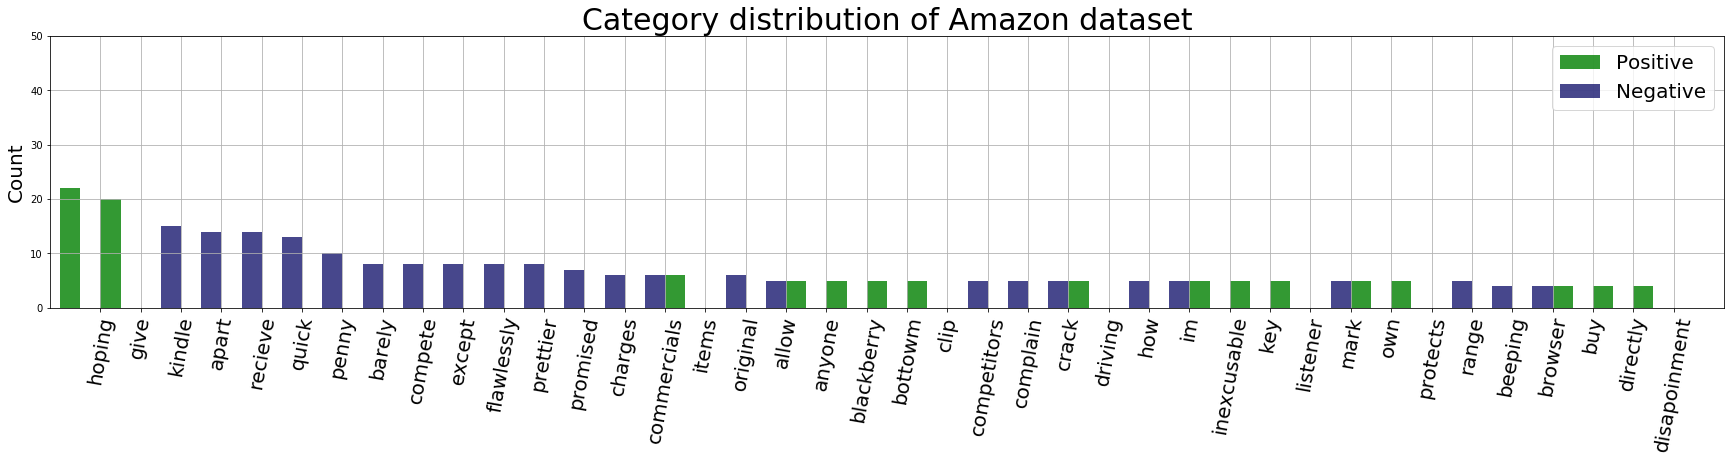

In [21]:
import matplotlib.pyplot as plt
# Setting the positions and width for the bars
pos = list(range(len(np.asarray(amazon_pos_disjoint_count_top)))) 
width = 0.5

# Plotting the bars
fig, ax = plt.subplots(figsize=(30,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, np.asarray(amazon_pos_disjoint_count_top), width, alpha=0.8, color='g',label='positive') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], np.asarray(amazon_neg_disjoint_count_top), width, alpha=0.8,color='midnightblue',label='negative') 

# Set the y axis label
ax.set_ylabel('Count',fontsize=20)

# Set the chart's title
ax.set_title('Category distribution of Amazon dataset',fontsize=30)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(myf.cat_subset_by_index(amazon_CV.get_feature_names(),amazon_disjoint_count_sort[0:40]),rotation=80,fontsize=20)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 50])

# Adding the legend and showing the plot
plt.legend(['Positive', 'Negative'], loc='upper right',fontsize=20)
plt.grid()
plt.show()


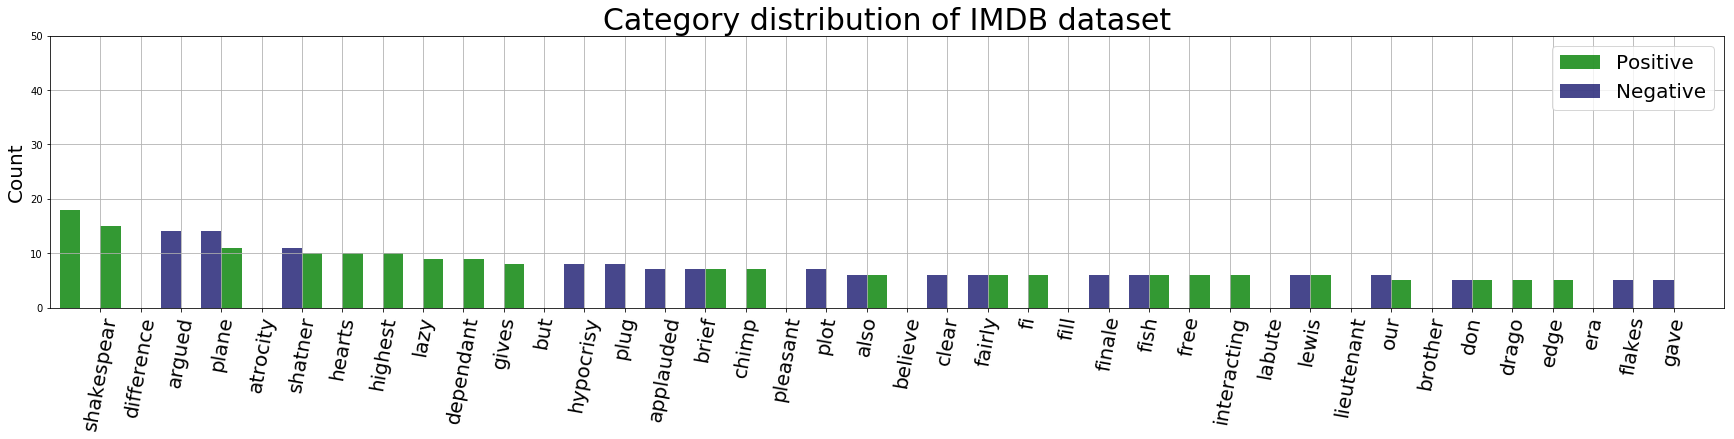

In [22]:
import matplotlib.pyplot as plt
# Setting the positions and width for the bars
pos = list(range(len(np.asarray(imdb_pos_disjoint_count_top)))) 
width = 0.5

# Plotting the bars
fig, ax = plt.subplots(figsize=(30,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, np.asarray(imdb_pos_disjoint_count_top), width, alpha=0.8, color='g',label='positive') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], np.asarray(imdb_neg_disjoint_count_top), width, alpha=0.8,color='midnightblue',label='negative') 

# Set the y axis label
ax.set_ylabel('Count',fontsize=20)

# Set the chart's title
ax.set_title('Category distribution of IMDB dataset',fontsize=30)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(myf.cat_subset_by_index(imdb_CV.get_feature_names(),imdb_disjoint_count_sort[0:40]),rotation=80,fontsize=20)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 50])

# Adding the legend and showing the plot
plt.legend(['Positive', 'Negative'], loc='upper right',fontsize=20)
plt.grid()
plt.show()

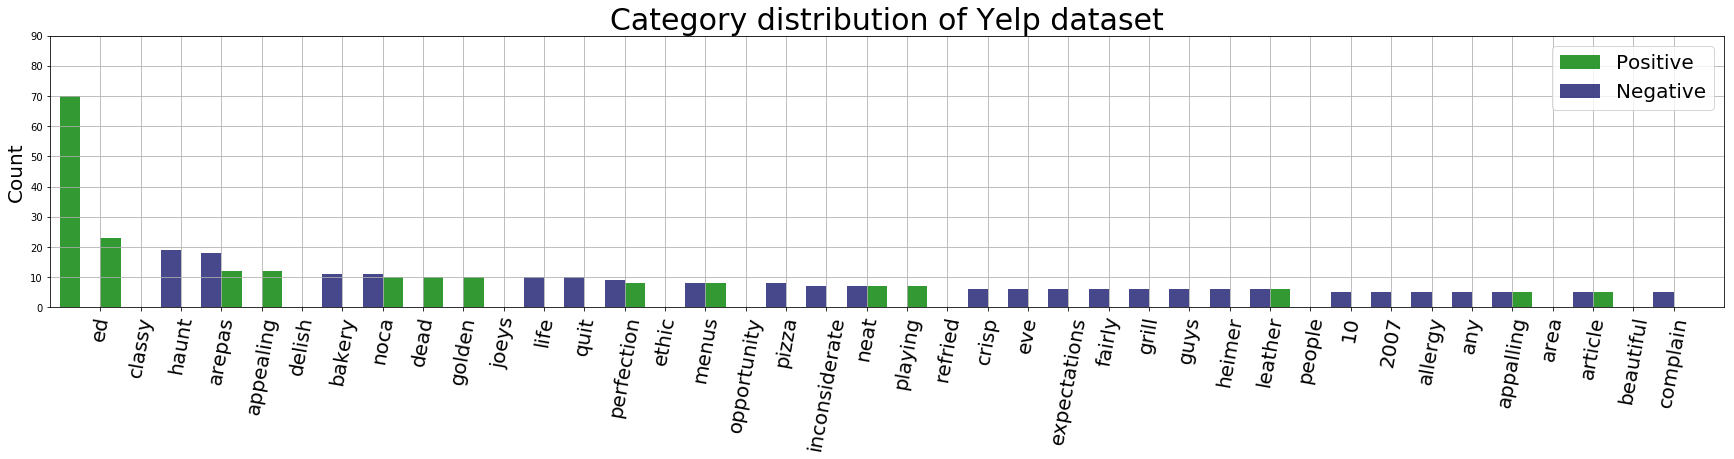

In [23]:
import matplotlib.pyplot as plt
# Setting the positions and width for the bars
pos = list(range(len(np.asarray(yelp_pos_disjoint_count_top)))) 
width = 0.5

# Plotting the bars
fig, ax = plt.subplots(figsize=(30,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, np.asarray(yelp_pos_disjoint_count_top), width, alpha=0.8, color='g',label='positive') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], np.asarray(yelp_neg_disjoint_count_top), width, alpha=0.8,color='midnightblue',label='negative') 

# Set the y axis label
ax.set_ylabel('Count',fontsize=20)

# Set the chart's title
ax.set_title('Category distribution of Yelp dataset',fontsize=30)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(myf.cat_subset_by_index(yelp_CV.get_feature_names(),yelp_disjoint_count_sort[0:40]),rotation=80,fontsize=20)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 90])

# Adding the legend and showing the plot
plt.legend(['Positive', 'Negative'], loc='upper right',fontsize=20)
plt.grid()
plt.show()